In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import librosa

# Sklean
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Input,Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
filepath = './data/data.json'
with open(filepath, "r") as fp:
    data = json.load(fp)


In [3]:
X = np.array(data["mfcc"])
y = np.array(data["genre_num"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# shape = (# samples, time-bins (x), num MFCCs (y))
print(f"X training data shape: {X_train.shape}, y training data shape: {y_train.shape}")
print(f"X validation data shape: {X_val.shape}, y validation data shape: {y_val.shape}")

X training data shape: (4890, 130, 13), y training data shape: (4890,)
X validation data shape: (2096, 130, 13), y validation data shape: (2096,)


**TRAINING WITH DNN**

In [6]:

model_dnn = Sequential()

# Add Input layer
model_dnn.add(Input(shape=X.shape[1:3]))

# Flatten to dense
model_dnn.add(Flatten())

# Create Dense Layers
model_dnn.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_dnn.add(Dropout(0.3))
model_dnn.add(Dense(10, activation='softmax'))

In [7]:
model_dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 1690)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       865,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,014,218 (3.87 MB)

 Trainable params: 1,014,218 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model_dnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)


In [13]:
hist_dnn = model_dnn.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - acc: 0.1330 - loss: 61.6288 - val_acc: 0.2586 - val_loss: 5.0486
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.1870 - loss: 14.1834 - val_acc: 0.3015 - val_loss: 3.5756
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - acc: 0.1849 - loss: 8.3542 - val_acc: 0.2591 - val_loss: 3.3783
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.1856 - loss: 6.3533 - val_acc: 0.1994 - val_loss: 3.3948
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.1822 - loss: 5.3075 - val_acc: 0.1970 - val_loss: 3.3909
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - acc: 0.1769 - loss: 4.4644 - val_acc: 0.1904 - val_loss: 3.4032
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.1572 - loss: 4.1776 - val_acc: 0.1670 - val_loss: 3.4378
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - acc: 0.1663 - loss: 3.9209 - val_acc: 0.1846 - val_loss: 3.4158
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - 

In [15]:
import pickle

# Save the model
model_dnn.save('model_dnn1.h5')

# Save the training history
with open('hist_dnn1.pkl', 'wb') as f:
    pickle.dump(hist_dnn.history, f)

print("Model and training history saved successfully!")

Model and training history saved successfully!


In [9]:
loss_dnn, acc_dnn = model_dnn.evaluate(X_test, y_test)
print(f"Test Loss: {loss_dnn}")
print(f"Test Accuracy: {acc_dnn}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.0990 - loss: 88.2381
Test Loss: 86.70426177978516
Test Accuracy: 0.09883138537406921


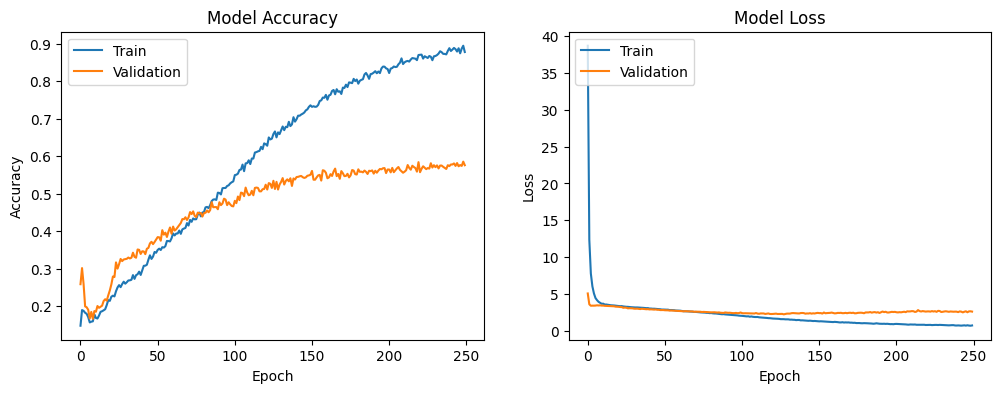

In [6]:
from tensorflow.keras.models import load_model
import pickle

# Load the model
model_dnn1 = load_model('model_dnn1.h5')

# Load the history
with open('hist_dnn1.pkl', 'rb') as f:
    hist_dnn1 = pickle.load(f)

# Now you can use loaded_model and loaded_history
# For example, to plot the training history:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist_dnn1['acc'])
plt.plot(hist_dnn1['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(hist_dnn1['loss'])
plt.plot(hist_dnn1['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [7]:
def plot_history(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist.history["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist.history["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist.history["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()


In [28]:
def plot_history2(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist["acc"], c='navy', label="Training Accuracy")
    axs[0].plot(hist["val_acc"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()


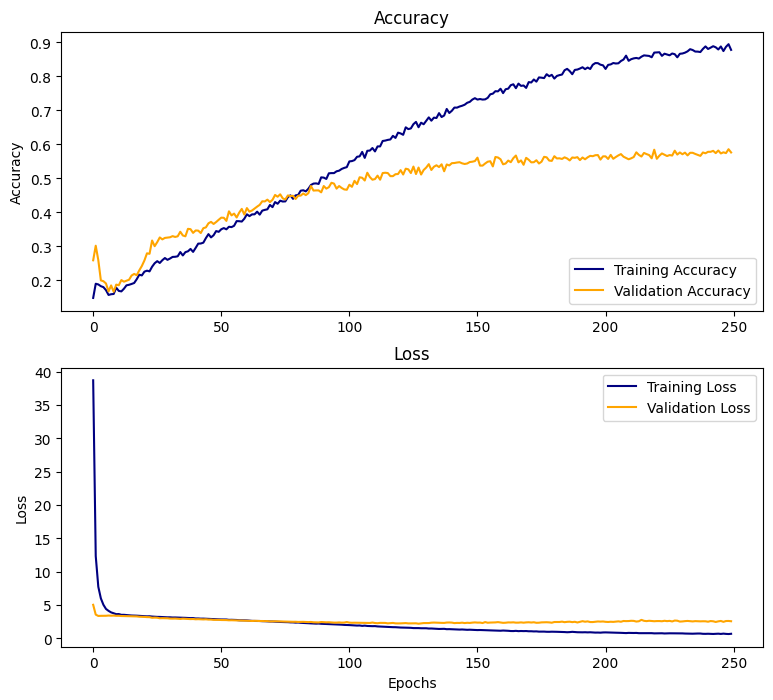

In [29]:
plot_history2(hist_dnn1)

In [42]:
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

input_shape = X_train_cnn.shape[1:4]
X_train_cnn.shape # shape = (# samples, time-bins (x), num MFCCs (y), "channel" (like an image))


(4890, 130, 13, 1)

**TRAINING WITH CNN WITHOUT REGULARIZATION**

In [20]:
model_cnn1 = Sequential()

# Create a convolution block
model_cnn1.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results

# Add another conv block
model_cnn1.add(Conv2D(64, 3, activation='relu'))
model_cnn1.add(MaxPooling2D(3, strides=(2,2), padding='same'))

# Add another conv block
model_cnn1.add(Conv2D(64, 2, activation='relu'))
model_cnn1.add(MaxPooling2D(2, strides=(2,2), padding='same'))


model_cnn1.add(Flatten())
model_cnn1.add(Dense(64, activation='relu'))

# output to 10 classes for predictions
model_cnn1.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification

c:\Users\Asus\Minor2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
model_cnn1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        61,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,418 (380.54 KB)

 Trainable params: 97,418 (380.54 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_cnn1.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)

In [23]:
hist_cnn1 = model_cnn1.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
)


Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - acc: 0.1864 - loss: 4.7698 - val_acc: 0.3397 - val_loss: 1.9375
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - acc: 0.3599 - loss: 1.8681 - val_acc: 0.4079 - val_loss: 1.6922
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - acc: 0.4345 - loss: 1.6199 - val_acc: 0.4346 - val_loss: 1.5812
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - acc: 0.4674 - loss: 1.4943 - val_acc: 0.4590 - val_loss: 1.5253
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - acc: 0.4983 - loss: 1.3918 - val_acc: 0.4823 - val_loss: 1.4426
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - acc: 0.5184 - loss: 1.3167 - val_acc: 0.4757 - val_loss: 1.4218
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - acc: 0.5351 - loss: 1.2930 - val_acc: 0.5010 - val_loss: 1.3659
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - acc: 0.5713 - loss: 1.2122 - val_acc: 0.5296 - val_loss: 1.3161
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - ac

In [24]:
model_cnn1.save('model_cnn1.h5')

# Save the training history
with open('hist_cnn1.pkl', 'wb') as f:
    pickle.dump(hist_cnn1.history, f)

print("Model and training history saved successfully!")

Model and training history saved successfully!


In [10]:
model_cnn1 = load_model('model_cnn1.h5')

# Load the history
with open('hist_cnn1.pkl', 'rb') as f:
    hist_cnn1 = pickle.load(f)

In [11]:
loss_cnn1, acc_cnn1 = model_cnn1.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn1}")
print(f"Test Accuracy: {acc_cnn1}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - acc: 0.6635 - loss: 2.3160
Test Loss: 2.2085182666778564
Test Accuracy: 0.6787980198860168


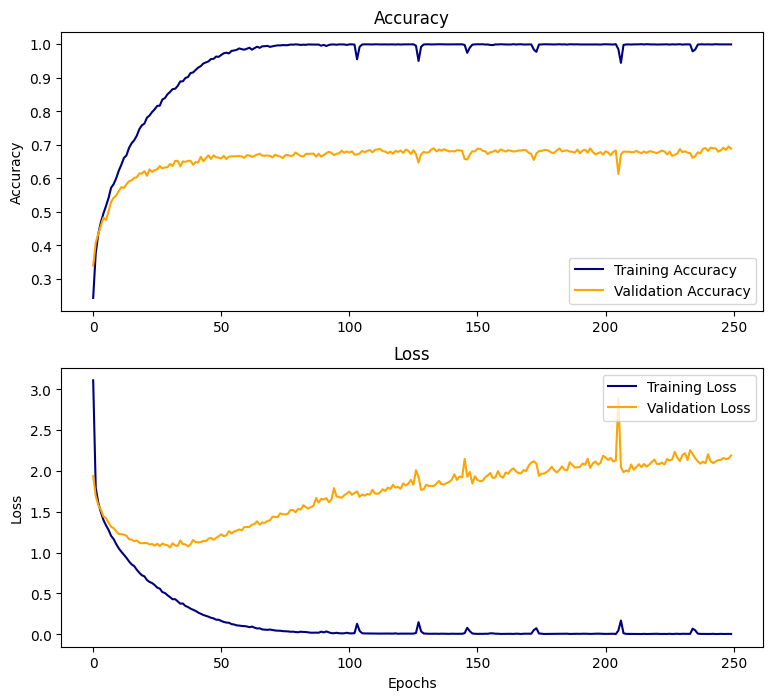

In [30]:
plot_history2(hist_cnn1)

**TRAINING WITH CNN WITH REGULARIZATION**

In [13]:
# Convolutional Neural Network - BEST

# Instantiate sequential model
model_cnn2 = Sequential()

# Create a convolution block
model_cnn2.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn2.add(Dropout(0.2))

# Add another conv block
model_cnn2.add(Conv2D(64, 3, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Add another conv block
model_cnn2.add(Conv2D(64, 2, activation='relu'))
model_cnn2.add(BatchNormalization())
model_cnn2.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn2.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn2.add(Flatten())
model_cnn2.add(Dense(128, activation='relu'))
model_cnn2.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn2.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification


c:\Users\Asus\Minor2\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model_cnn2.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [15]:
model_cnn2.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)


In [16]:
es_cnn2 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 

In [17]:
hist_cnn2 = model_cnn2.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=250,
    verbose=1
#     callbacks=[es_cnn2]
)

Epoch 1/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 17s 179ms/step - acc: 0.1369 - loss: 3.5178 - val_acc: 0.2347 - val_loss: 2.2262
Epoch 2/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 173ms/step - acc: 0.2413 - loss: 2.6262 - val_acc: 0.3392 - val_loss: 1.9367
Epoch 3/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 185ms/step - acc: 0.2949 - loss: 2.1842 - val_acc: 0.3927 - val_loss: 1.8269
Epoch 4/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 14s 186ms/step - acc: 0.3448 - loss: 1.9774 - val_acc: 0.4084 - val_loss: 1.7965
Epoch 5/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 156ms/step - acc: 0.3883 - loss: 1.7878 - val_acc: 0.4284 - val_loss: 1.7008
Epoch 6/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - acc: 0.4122 - loss: 1.7129 - val_acc: 0.4451 - val_loss: 1.6415
Epoch 7/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - acc: 0.4039 - loss: 1.6527 - val_acc: 0.4585 - val_loss: 1.6329
Epoch 8/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 13s 167ms/step - acc: 0.4351 - loss: 1.5729 - val_acc: 0.4900 - val_loss: 1.5390
Epoch 9/250
77/77 ━━━━━━━━━━━━━━━━━━━━ 1

In [18]:
model_cnn1.save('model_cnn2.h5')

# Save the training history
with open('hist_cnn2.pkl', 'wb') as f:
    pickle.dump(hist_cnn2.history, f)

print("Model and training history saved successfully!")

Model and training history saved successfully!


In [36]:
model_cnn2 = load_model('model_cnn2.h5')

# Load the history
with open('hist_cnn2.pkl', 'rb') as f:
    hist_cnn2 = pickle.load(f)

In [19]:
loss_cnn2, acc_cnn2 = model_cnn2.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn2}")
print(f"Test Accuracy: {acc_cnn2}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7812 - loss: 0.8529
Test Loss: 0.8460055589675903
Test Accuracy: 0.7886477708816528


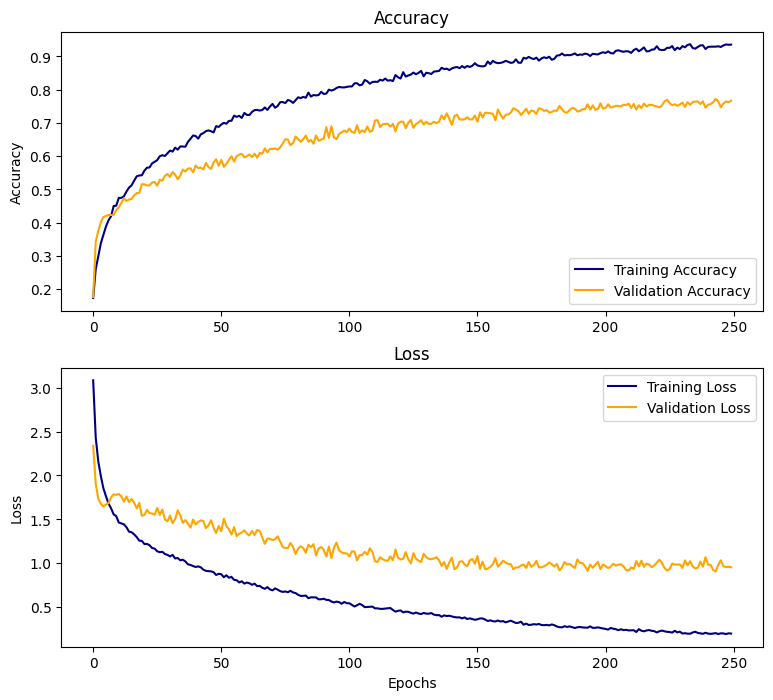

In [39]:
plot_history(hist_cnn2)


**Convolutional Neural Network (With Regularization and Data Augmentation)**

In [40]:
model_cnn3 = Sequential()

# Create a convolution block
model_cnn3.add(Conv2D(32, 3, activation='relu', input_shape=input_shape)) # first hidden conv layer
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same')) # MaxPool the results
model_cnn3.add(Dropout(0.2))

# Add another conv block
model_cnn3.add(Conv2D(64, 3, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(3, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Add another conv block
model_cnn3.add(Conv2D(64, 2, activation='relu'))
model_cnn3.add(BatchNormalization())
model_cnn3.add(MaxPooling2D(2, strides=(2,2), padding='same'))
model_cnn3.add(Dropout(0.1))

# Flatten output to send through dense layers
model_cnn3.add(Flatten())
model_cnn3.add(Dense(128, activation='relu'))
model_cnn3.add(Dropout(0.5))

# output to 10 classes for predictions
model_cnn3.add(Dense(10, activation='softmax')) # Softmax activation for multi-class classification


In [41]:
model_cnn3.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 11, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 11, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 62, 4, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 62, 4, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 31, 2, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 30, 1, 64)      │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 30, 1, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 15, 1, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       123,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 159,882 (624.54 KB)

 Non-trainable params: 320 (1.25 KB)

In [42]:
model_cnn3.compile(
    optimizer=Adam(learning_rate=0.0001), # can also use 'adam'
    loss='sparse_categorical_crossentropy', # loss for multi-class classification
    metrics=['acc']
)


In [43]:

# Datagen
datagen = ImageDataGenerator(vertical_flip=True)


In [44]:
es_cnn3 = EarlyStopping(monitor='val_loss', patience=20, min_delta=0) 


In [ ]:
hist_cnn3 = model_cnn3.fit(
    datagen.flow(X_train_cnn, y_train),
    validation_data=(X_val_cnn, y_val),
    batch_size=64,
    epochs=400,
    verbose=1
#     callbacks=[es_cnn]
)

In [43]:
from tensorflow.keras.models import load_model
model_cnn3 = load_model('model_cnn3.h5')
with open('hist_cnn3.pkl', 'rb') as f:
    hist_cnn3 = pickle.load(f)

In [44]:
loss_cnn3, acc_cnn3 = model_cnn3.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_cnn3}")
print(f"Test Accuracy: {acc_cnn3}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - acc: 0.8322 - loss: 0.7066
Test Loss: 0.6552037596702576
Test Accuracy: 0.844407320022583


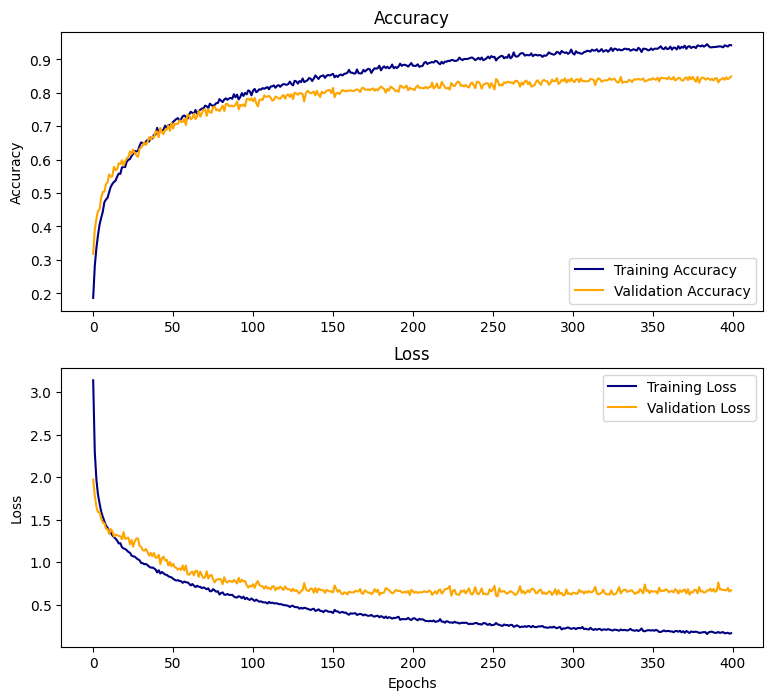

In [32]:
plot_history2(hist_cnn3)

**RECURRENT NEURAL NETWORK**

In [22]:
# Import the RNN model functions
from rnn_model import train_rnn_model, evaluate_rnn_model

# Train the RNN model
model_rnn, history_rnn = train_rnn_model(
    X_train, y_train,
    X_val, y_val,
    model_save_path='model_rnn.h5'
)

# Evaluate the model on test set
y_pred_classes, y_pred = evaluate_rnn_model(model_rnn, X_test, y_test)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Epoch 1/100
153/153 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.3763 - loss: 1.9145

153/153 ━━━━━━━━━━━━━━━━━━━━ 76s 428ms/step - accuracy: 0.3768 - loss: 1.9127 - val_accuracy: 0.1775 - val_loss: 2.2875
Epoch 2/100
 15/153 ━━━━━━━━━━━━━━━━━━━━ 53s 390ms/step - accuracy: 0.5079 - loss: 1.4590

KeyboardInterrupt: 

In [ ]:

with open('hist_rnn.pkl', 'wb') as f:
    pickle.dump(history_rnn.history, f)

print("Model and training history saved successfully!")

**TRANSFORMER MODEL**

In [ ]:
# Import the Transformer model functions
from transformer_model import train_transformer_model, evaluate_transformer_model

# Train the Transformer model
model_transformer, history_transformer = train_transformer_model(
    X_train, y_train,
    X_val, y_val,
    model_save_path='model_transformer.h5'
)


In [ ]:
y_pred_classes, y_pred = evaluate_transformer_model(model_transformer, X_test, y_test)

# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history_transformer.history['accuracy'], label='Training Accuracy')
plt.plot(history_transformer.history['val_accuracy'], label='Validation Accuracy')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_transformer.history['loss'], label='Training Loss')
plt.plot(history_transformer.history['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

with open('hist_transformer.pkl', 'wb') as f:
    pickle.dump(history_transformer.history, f)

print("Model and training history saved successfully!")

**AUTOENCODER MODEL**

In [ ]:
from autoencoder_model import (
    train_autoencoder, train_classifier,
    evaluate_autoencoder_classifier
)

# First, train the autoencoder
autoencoder, encoder, history_autoencoder = train_autoencoder(
    X_train, X_val,
    model_save_path='model_autoencoder.h5'
)

In [ ]:
classifier, history_classifier = train_classifier(
    encoder, X_train, y_train,
    X_val, y_val,
    model_save_path='model_classifier.h5'
)

In [ ]:

y_pred_classes, y_pred = evaluate_autoencoder_classifier(
    encoder, classifier, X_test, y_test
)

# Plot training histories
plt.figure(figsize=(15, 5))

# Plot autoencoder loss
plt.subplot(1, 3, 1)
plt.plot(history_autoencoder.history['loss'], label='Training Loss')
plt.plot(history_autoencoder.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Reconstruction Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot classifier accuracy
plt.subplot(1, 3, 2)
plt.plot(history_classifier.history['accuracy'], label='Training Accuracy')
plt.plot(history_classifier.history['val_accuracy'], label='Validation Accuracy')
plt.title('Classifier Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot classifier loss
plt.subplot(1, 3, 3)
plt.plot(history_classifier.history['loss'], label='Training Loss')
plt.plot(history_classifier.history['val_loss'], label='Validation Loss')
plt.title('Classifier Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

with open('hist_autoencoder.pkl', 'wb') as f:
    pickle.dump(history_autoencoder.history, f)

print("Model and training history saved successfully!")

In [ ]:

with open('hist_classifier.pkl', 'wb') as f:
    pickle.dump(history_classifier.history, f)

print("Model and training history saved successfully!")

In [23]:

with open('hist_transformer.pkl', 'rb') as f:
    hist_transformer = pickle.load(f)

KeyError: 'acc'

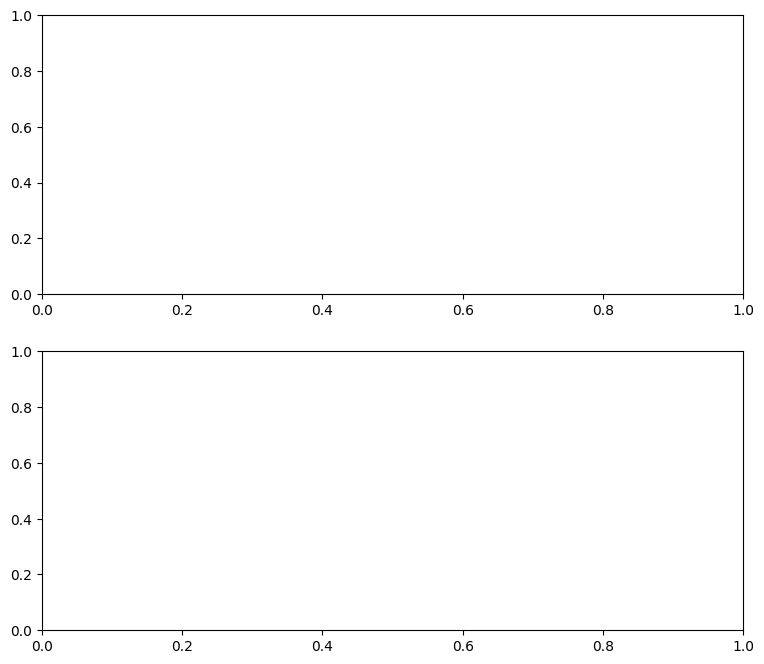

In [33]:
def plot_history2(hist):
    """Plots the accuracy and loss for a model over the course of all epochs
    
    Parameters:
        hist (keras history object): The recorded history of model.fit() to be plotted
    """
    fig, axs = plt.subplots(2, 1, figsize=(8,7))
    fig.tight_layout(pad=2)
    
    # Accuracy subplot
    axs[0].plot(hist["accuracy"], c='navy', label="Training Accuracy")
    axs[0].plot(hist["val_accuracy"], c='orange', label="Validation Accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy")
    
    # Error subplot
    axs[1].plot(hist["loss"], c='navy', label="Training Loss")
    axs[1].plot(hist["val_loss"], c='orange', label="Validation Loss")    
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epochs")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss")
    
    plt.show()


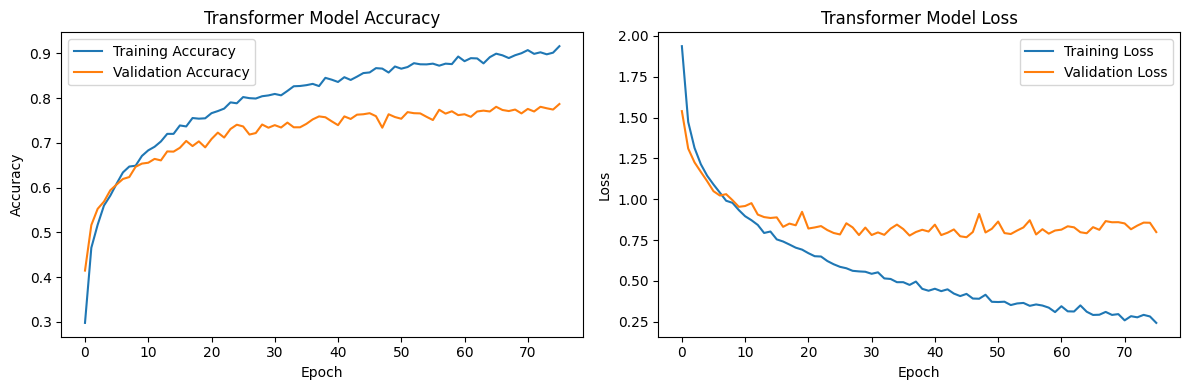

In [34]:
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(hist_transformer['accuracy'], label='Training Accuracy')
plt.plot(hist_transformer['val_accuracy'], label='Validation Accuracy')
plt.title('Transformer Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(hist_transformer['loss'], label='Training Loss')
plt.plot(hist_transformer['val_loss'], label='Validation Loss')
plt.title('Transformer Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
from tensorflow.keras.models import load_model
from transformer_model import TransformerBlock 
model_transformer = load_model('model_transformer.h5', custom_objects={'TransformerBlock': TransformerBlock})
with open('hist_transformer.pkl', 'rb') as f:
    hist_cnn3 = pickle.load(f)

In [47]:
loss_tr, acc_tr = model_transformer.evaluate(X_test_cnn, y_test)
print(f"Test Loss: {loss_tr}")
print(f"Test Accuracy: {acc_tr}")


94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.7879 - loss: 0.7993
Test Loss: 0.7689802050590515
Test Accuracy: 0.794991672039032


CNN1 Test Accuracy: 0.6788
CNN2 Test Accuracy: 0.6788
CNN3 Test Accuracy: 0.8444
DNN Test Accuracy: 0.5816
Transformer Test Accuracy: 0.7950


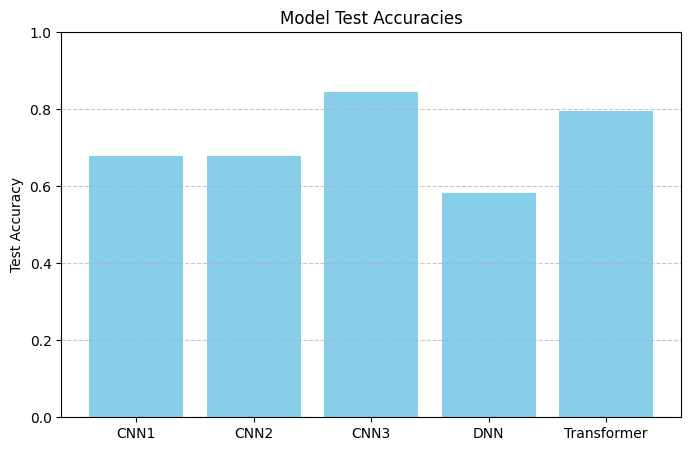

In [51]:
import matplotlib.pyplot as plt

model_cnn1 = load_model("model_cnn1.h5")
model_cnn2 = load_model("model_cnn2.h5")
model_cnn3 = load_model("model_cnn3.h5")
model_dnn = load_model("model_dnn1.h5")
model_rnn = load_model("model_rnn.h5")
model_transformer = lo
# Evaluate all models and store their accuracies
models = {
    'CNN1': model_cnn1,
    'CNN2': model_cnn2,
    'CNN3': model_cnn3,
    'DNN': model_dnn,
    'Transformer': model_transformer
}

accuracies = {}

for name, model in models.items():
    _, acc = model.evaluate(X_test_cnn, y_test, verbose=0)
    accuracies[name] = acc
    print(f"{name} Test Accuracy: {acc:.4f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)
plt.title('Model Test Accuracies')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**CLASSICAL MODELS**


Training SVM...
SVM Accuracy: 0.5272

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.51      0.49       209
           1       0.75      0.86      0.80       210
           2       0.39      0.28      0.33       209
           3       0.41      0.33      0.37       210
           4       0.56      0.31      0.40       210
           5       0.54      0.62      0.58       208
           6       0.64      0.79      0.70       210
           7       0.52      0.80      0.63       210
           8       0.54      0.50      0.52       210
           9       0.32      0.27      0.29       210

    accuracy                           0.53      2096
   macro avg       0.51      0.53      0.51      2096
weighted avg       0.51      0.53      0.51      2096



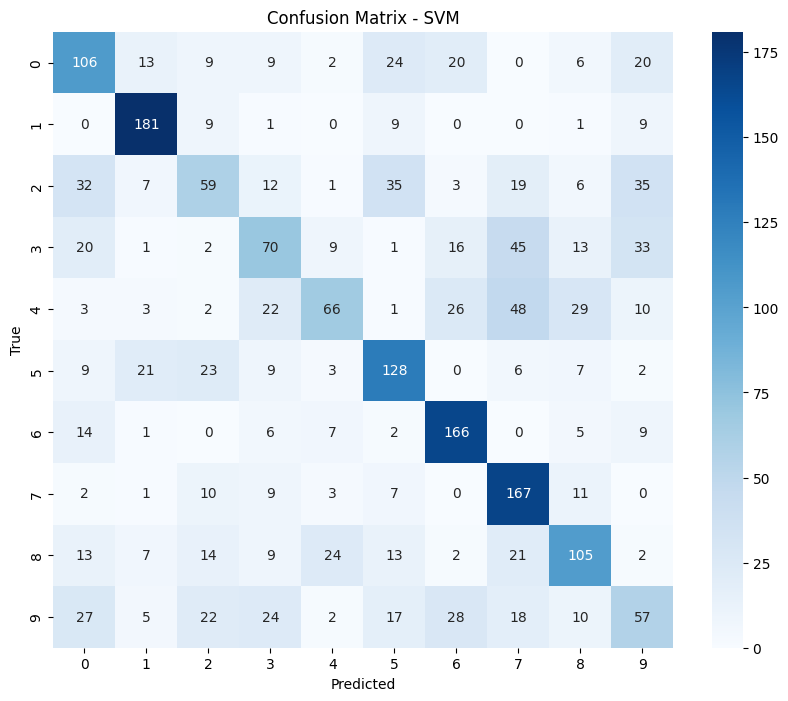


Training KNN...
KNN Accuracy: 0.4113

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.36      0.47       209
           1       0.55      0.97      0.70       210
           2       0.26      0.37      0.31       209
           3       0.47      0.19      0.27       210
           4       0.69      0.10      0.17       210
           5       0.25      0.66      0.36       208
           6       0.49      0.89      0.63       210
           7       0.71      0.17      0.27       210
           8       1.00      0.04      0.08       210
           9       0.36      0.37      0.37       210

    accuracy                           0.41      2096
   macro avg       0.55      0.41      0.36      2096
weighted avg       0.55      0.41      0.36      2096



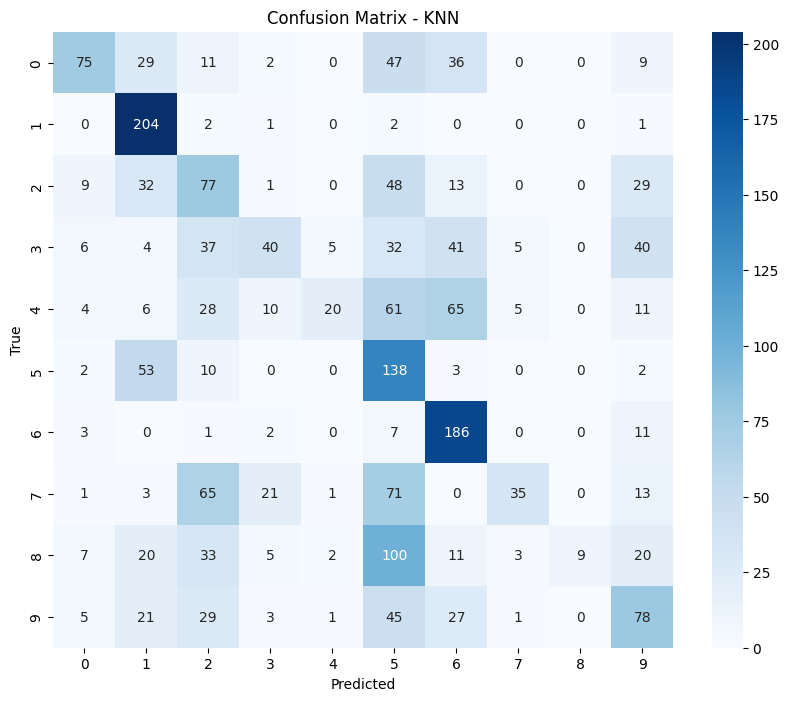


Training Random Forest...
Random Forest Accuracy: 0.5530

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       209
           1       0.75      0.92      0.83       210
           2       0.43      0.32      0.37       209
           3       0.47      0.43      0.45       210
           4       0.59      0.34      0.43       210
           5       0.53      0.64      0.58       208
           6       0.61      0.82      0.70       210
           7       0.51      0.82      0.63       210
           8       0.59      0.45      0.51       210
           9       0.39      0.27      0.32       210

    accuracy                           0.55      2096
   macro avg       0.54      0.55      0.54      2096
weighted avg       0.54      0.55      0.54      2096



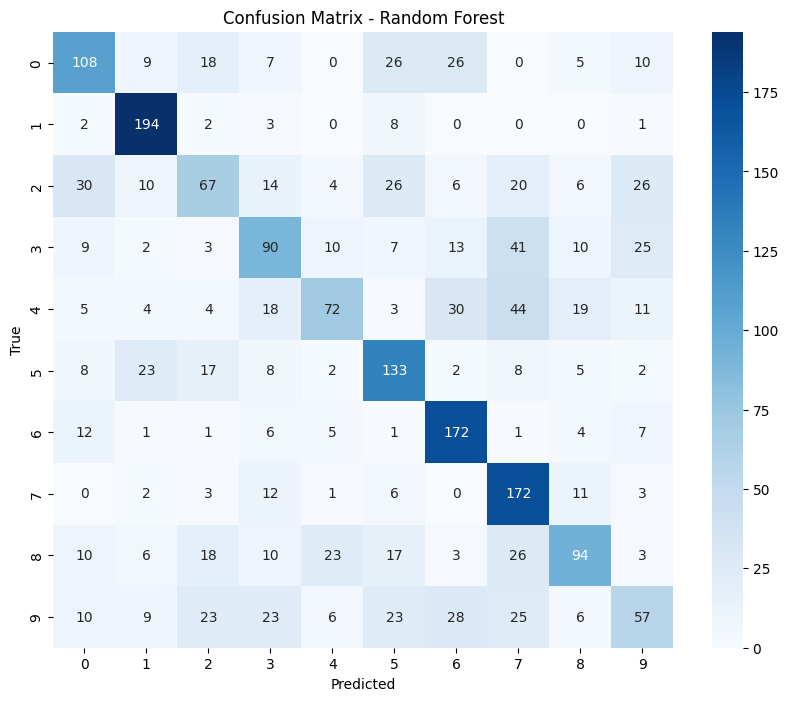

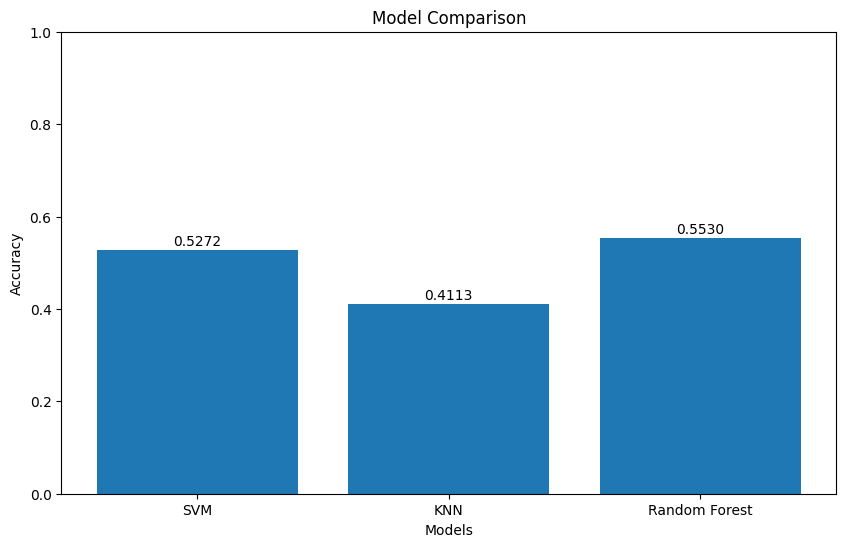


Best performing model: Random Forest with accuracy 0.5530
Best model saved as 'best_model.joblib'


In [8]:
# Import required libraries
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Reshape the data from 3D to 2D
# Assuming X_train and X_val are in shape (n_samples, time_steps, n_features)
n_samples_train = X_train.shape[0]
n_samples_val = X_val.shape[0]

# Reshape to (n_samples, time_steps * n_features)
X_train_reshaped = X_train.reshape(n_samples_train, -1)
X_val_reshaped = X_val.reshape(n_samples_val, -1)

# Initialize models
svm = SVC(kernel='rbf', probability=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Dictionary to store models and their names
models = {
    'SVM': svm,
    'KNN': knn,
    'Random Forest': rf
}

# Train and evaluate each model
results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Train the model
    model.fit(X_train_reshaped, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val_reshaped)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_val, y_pred)
    results[name] = accuracy
    
    # Print results
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Compare model performances
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for i, v in enumerate(results.values()):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')
plt.show()

# Save the best model
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name} with accuracy {results[best_model_name]:.4f}")

# Save the best model
import joblib
joblib.dump(best_model, 'best_model.joblib')
print("Best model saved as 'best_model.joblib'")

In [5]:
   # Import the AST model
from ast_model import train_ast_model
   
   # Train the model
model, history = train_ast_model(X_train, y_train, X_val, y_val, X_test, y_test, num_epochs=50)
   
   # Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
   
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
   
plt.tight_layout()
plt.show()

c:\Users\Asus\Minor2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Asus\Minor2\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


: 

In [5]:
from clap_model import train_clap_model

# Train the model
model, history = train_clap_model(X_train, y_train, X_val, y_val, X_test, y_test, num_epochs=50)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

c:\Users\Asus\Minor2\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Asus\Minor2\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


: 